# Google Colab Specific

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpu0u4yk0c/pubring.gpg' created
gpg: /tmp/tmpu0u4yk0c/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


KeyboardInterrupt: ignored

In [3]:
# Mount Google Drive
!mkdir -p gdrive
!google-drive-ocamlfuse gdrive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# Environment Setup

In [4]:
# Change Working Directory/
import os
os.chdir('gdrive/Dog_Breed_Classifier')

!ls
!ls Data

bottleneck_features  Dog_Breed_Classifier.ipynb  justins_utils.py
Data		     fc_model_weights		 __pycache__
data_matrices	     full_model_weights		 scraped_photos
labels.csv  preds.csv  sample_submission.csv


In [4]:
!pip install -q keras
!pip install -q tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from IPython.display import SVG
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

from PIL import Image

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Lambda, GaussianNoise
from keras.regularizers import l2, l1
from keras.optimizers import SGD
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Helper Functions

In [0]:
exec(open('justins_utils.py').read())
# path_to_arr(path, target_dim=299)
# plot_model_history(history)
# get_errors(yhat, y)
# print_input_shapes(split_data)
# split_train_cv(x, y, cv_frac)

In [0]:
def show_errors(x, errors, to_class_dict):
  nrows = 3
  ncols = 10
  dim = 7
  
  fig = plt.figure(1, figsize=(nrows*dim, ncols*dim))
  grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.05)

  for i, ax in enumerate(grid):
    image = x[errors[:, i][0]]
    pred_label   = to_class_dict[errors[:, i][1]]
    actual_label = to_class_dict[errors[:, i][2]]

    ax.imshow(image)
    ax.text(10, 330, 'pred: ' + pred_label, color='w', bbox=dict(facecolor='black', alpha=0.7))
    ax.text(10, 380, 'actual: ' + actual_label, color='w', bbox=dict(facecolor='black', alpha=0.7))
    ax.axis('off')

In [0]:
def plot_confusion_matrix(errors, N_CLASSES, cmap="YlGnBu"):
  c_mat = confusion_matrix(y_true=errors[2], y_pred=errors[1])
  fig = plt.figure(1, figsize=(20, 14))
  fig = sns.heatmap(c_mat, 
                    xticklabels=list(num_to_class.values()),
                    yticklabels=list(num_to_class.values()),
                    linewidths=0.5,
                    cmap=cmap
                   )

In [0]:
def view_labeled_data(x, y, nrows, ncols, dim, rand=True):

  fig = plt.figure(1, figsize=(dim*nrows, dim*ncols))
  grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.05)

  for i, ax in enumerate(grid):
    if rand:
      i = np.random.randint(0, x.shape[0])
    ax.imshow(x[i])
    ax.text(5, 380, 
            s=num_to_class[np.argmax(y[i])], 
            color='w', 
            bbox=dict(facecolor='black', alpha=0.8))
    ax.axis('off')

# Global Settings

In [0]:
# Settings Live Here
N_CLASSES = 120
IMG_DIM = 400
CV_FRAC = 0.1

np.random.seed(2018)

# Data Setup

[RangeIndex(start=0, stop=10222, step=1),
 Index(['id', 'breed'], dtype='object')]

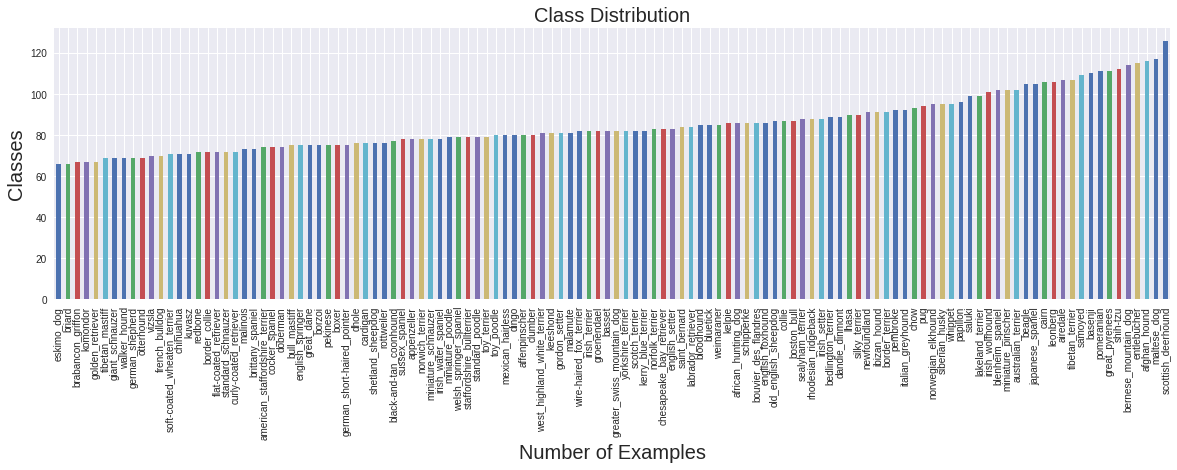

In [10]:
# Get Data from CSV
labels = pd.read_csv('Data/labels.csv')
display(labels.axes)

# Show class distribution
ax = pd.value_counts(labels['breed'], ascending=True).plot(kind='bar', 
                                                           title='Class Distribution',
                                                           fontsize='4', 
                                                           figsize=(20,5))
# Plot settings
ax.set(xlabel="Number of Examples", ylabel="Classes")
ax.tick_params(labelsize=10)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

In [0]:
# Make (sorted) list of TOP_CLASSES most common breeds
most_common_breeds = sorted(list(labels.groupby('breed')
                                 .count()
                                 .sort_values(by='id', ascending=False)
                                 .head(N_CLASSES)
                                 .index))

# Create dictionaries for interconverting between representations
num_to_class = dict(zip(range(N_CLASSES), most_common_breeds))
class_to_num = dict(zip(most_common_breeds, range(N_CLASSES)))

# Shrink label set to only include breeds in most_common_breeds
reduced_labels = labels[labels['breed'].isin(most_common_breeds)]

x.shape = (10222, 400, 400, 3)
y.shape = (10222, 120)


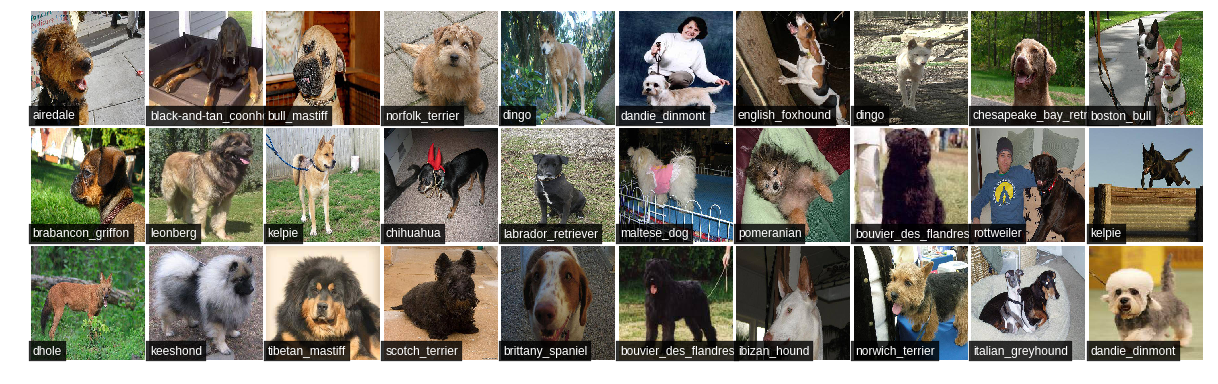

In [12]:
# Get x and y matrices

# Cell Settings
using_saved_xy = True
xpath = 'data_matrices/x_{}.npy'.format(IMG_DIM)
ypath = 'data_matrices/y_{}.npy'.format(IMG_DIM)

"""
External References:
  IMG_DIM
  N_CLASSES
  reduced_labels
  class_to_num
"""

if using_saved_xy:
  # Load previously set up x, y matrices
  x = np.load(xpath)
  y = np.load(ypath)

else:
  # Generate data_matrix
  data_matrix = reduced_labels.as_matrix()
  for i in tqdm(range(reduced_labels.shape[0])):
    path = 'Data/{}/{}.jpg'.format('train', data_matrix[i, 0])
    data_matrix[i, 0] = path_to_arr(path, target_size=IMG_DIM)
    data_matrix[i, 1] = class_to_num[data_matrix[i, 1]]
  
  print('data_matrix.shape = {}'.format(data_matrix.shape))
  # Generate and save x, y matrices
  x = np.stack(data_matrix[:,0])
  y = keras.utils.to_categorical(data_matrix[:, 1], num_classes=N_CLASSES)
  np.save(xpath, x)
  np.save(ypath, y)

# Put original data into dictionary for safekeeping
orig_data = {'x' : x,
             'y' : y}

# Sanity Checks
print_input_shapes(orig_data)
view_labeled_data(x=x, y=y, nrows=3, ncols=10, dim=7)

# First Attempt

**Start by generating bottleneck features**

In [0]:
def load_bottleneck_features(model_name, img_dim):
  bfs = np.load('bottleneck_features/{}_{}.npy'.format(model_name, img_dim))
  print('bfs.shape from {} = {}'.format(model_name, bfs.shape))
  return bfs


def generate_bottleneck_features(x, model_constructor, model_preprocessor, img_dim, saving=True, model_name=None):
  tensor_shape = (img_dim, img_dim, 3)
  
  # Define base CNN
  base_model = model_constructor(input_shape=tensor_shape, 
                                 weights='imagenet', 
                                 include_top=False, 
                                 pooling='avg')
  
  # Model layers
  model_input = Input(shape=tensor_shape, name='model_input')
  a = Lambda(model_preprocessor, name='preprocessing')(model_input)
  a = base_model(a)
  
  # Define bfs_model
  bfs_model = Model(inputs=model_input, outputs=a)
  
  # Generate bottleneck features
  bfs = bfs_model.predict(x)
  
  if saving:
    np.save('bottleneck_features/{}_{}.npy'.format(model_name, img_dim), bfs)
    
  print('bfs.shape from {} = {}'.format(model_name, bfs.shape))
  return bfs

In [14]:
# Xception Bottleneck Features
from keras.applications.xception import Xception, preprocess_input

# Cell Settings
loading_xception_bfs = True
generating_xception_bfs = False

if loading_xception_bfs:
  bfs_xception = load_bottleneck_features('xception', IMG_DIM)
elif generating_xception_bfs:
  x = orig_data['x']
  bfs_xception = generate_bottleneck_features(x, 
                                              model_constructor=Xception, 
                                              model_preprocessor=keras.applications.xception.preprocess_input, 
                                              img_dim=IMG_DIM, 
                                              saving=True, 
                                              model_name='xception')

bfs.shape from xception = (10222, 2048)


**Set up the fully connected model that will make predictions from bottleneck features**

In [0]:
def fc_setup(input_dim=2048):
  model_input = Input((input_dim,), name='model_input')
  a = Dropout(0.6)(model_input)
  probs = Dense(N_CLASSES, activation='softmax', name='probs')(a)

  fc_model = Model(inputs=model_input, outputs=probs)

  fc_model.compile(loss='categorical_crossentropy', 
              optimizer='adadelta', 
              metrics=['accuracy'])

  fc_model.summary()
  
  return fc_model

In [16]:
y = orig_data['y']

bfs_xception_split, permut_tr, permut_cv = split_train_cv(bfs_xception, y, CV_FRAC)

x.shape = (10222, 2048)
y.shape = (10222, 120)
x_tr.shape = (9199, 2048)
y_tr.shape = (9199, 120)
x_cv.shape = (1023, 2048)
y_cv.shape = (1023, 120)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
probs (Dense)                (None, 120)               245880    
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________
x.shape = (10222, 2048)
y.shape = (10222, 120)
x_tr.shape = (9199, 2048)
y_tr.shape = (9199, 120)
x_cv.shape = (1023, 2048)
y_cv.shape = (1023, 120)


Fitting...
Train on 9199 samples, validate on 1023 samples
Epoch 1/30
9199/9199 [==============================] - 4s 388us/step - loss: 2.5209 - acc: 0.6842 - val_loss: 1.0828 - val_acc: 0.8817
Epoch 2/30
9199/9199 [==============================] 

9199/9199 [==============================] - 1s 153us/step - loss: 0.3586 - acc: 0.9240 - val_loss: 0.3596 - val_acc: 0.9032
Epoch 5/30
9199/9199 [==============================] - 1s 161us/step - loss: 0.3130 - acc: 0.9273 - val_loss: 0.3311 - val_acc: 0.9110
Epoch 6/30
9199/9199 [==============================] - 1s 159us/step - loss: 0.2866 - acc: 0.9272 - val_loss: 0.3150 - val_acc: 0.9091
Epoch 7/30
9199/9199 [==============================] - 1s 155us/step - loss: 0.2652 - acc: 0.9328 - val_loss: 0.3069 - val_acc: 0.9091
Epoch 8/30
9199/9199 [==============================] - 1s 155us/step - loss: 0.2501 - acc: 0.9327 - val_loss: 0.2999 - val_acc: 0.9091
Epoch 9/30
9199/9199 [==============================] - 1s 158us/step - loss: 0.2397 - acc: 0.9341 - val_loss: 0.2931 - val_acc: 0.9120
Epoch 10/30
9199/9199 [==============================] - 1s 155us/step - loss: 0.2322 - acc: 0.9353 - val_loss: 0.2872 - val_acc: 0.9110
Epoch 11/30
1056/9199 [==>...........................] - E

9199/9199 [==============================] - 1s 158us/step - loss: 0.2257 - acc: 0.9352 - val_loss: 0.2851 - val_acc: 0.9101
Epoch 12/30
9199/9199 [==============================] - 1s 157us/step - loss: 0.2198 - acc: 0.9376 - val_loss: 0.2812 - val_acc: 0.9101
Epoch 13/30
9199/9199 [==============================] - 1s 154us/step - loss: 0.2164 - acc: 0.9374 - val_loss: 0.2786 - val_acc: 0.9091
Epoch 14/30
9199/9199 [==============================] - 1s 155us/step - loss: 0.2040 - acc: 0.9415 - val_loss: 0.2761 - val_acc: 0.9101
Epoch 15/30
9199/9199 [==============================] - 1s 153us/step - loss: 0.2053 - acc: 0.9424 - val_loss: 0.2734 - val_acc: 0.9120
Epoch 16/30
9199/9199 [==============================] - 1s 158us/step - loss: 0.2020 - acc: 0.9403 - val_loss: 0.2784 - val_acc: 0.9110
Epoch 17/30
9199/9199 [==============================] - 1s 153us/step - loss: 0.1973 - acc: 0.9427 - val_loss: 0.2746 - val_acc: 0.9130
Epoch 18/30
 704/9199 [=>............................

9199/9199 [==============================] - 1s 153us/step - loss: 0.1947 - acc: 0.9446 - val_loss: 0.2740 - val_acc: 0.9101
Epoch 19/30
9199/9199 [==============================] - 1s 155us/step - loss: 0.1870 - acc: 0.9465 - val_loss: 0.2717 - val_acc: 0.9130
Epoch 20/30
9199/9199 [==============================] - 1s 156us/step - loss: 0.1910 - acc: 0.9450 - val_loss: 0.2728 - val_acc: 0.9120
Epoch 21/30
9199/9199 [==============================] - 1s 156us/step - loss: 0.1852 - acc: 0.9445 - val_loss: 0.2726 - val_acc: 0.9101
Epoch 22/30
9199/9199 [==============================] - 1s 154us/step - loss: 0.1847 - acc: 0.9465 - val_loss: 0.2744 - val_acc: 0.9110
Epoch 23/30
9199/9199 [==============================] - 1s 160us/step - loss: 0.1833 - acc: 0.9451 - val_loss: 0.2730 - val_acc: 0.9130
Epoch 24/30
9199/9199 [==============================] - 1s 153us/step - loss: 0.1780 - acc: 0.9479 - val_loss: 0.2700 - val_acc: 0.9120
Epoch 25/30
 768/9199 [=>............................

9199/9199 [==============================] - 1s 153us/step - loss: 0.1786 - acc: 0.9479 - val_loss: 0.2699 - val_acc: 0.9110
Epoch 26/30
9199/9199 [==============================] - 1s 151us/step - loss: 0.1768 - acc: 0.9489 - val_loss: 0.2707 - val_acc: 0.9120
Epoch 27/30
9199/9199 [==============================] - 1s 153us/step - loss: 0.1712 - acc: 0.9490 - val_loss: 0.2726 - val_acc: 0.9140
Epoch 28/30
9199/9199 [==============================] - 1s 150us/step - loss: 0.1688 - acc: 0.9496 - val_loss: 0.2729 - val_acc: 0.9159
Epoch 29/30
9199/9199 [==============================] - 1s 152us/step - loss: 0.1699 - acc: 0.9501 - val_loss: 0.2723 - val_acc: 0.9140
Epoch 30/30
1023/1023 [==============================] - 0s 73us/step
[0.26845710062561146, 0.9149560118467344]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


None

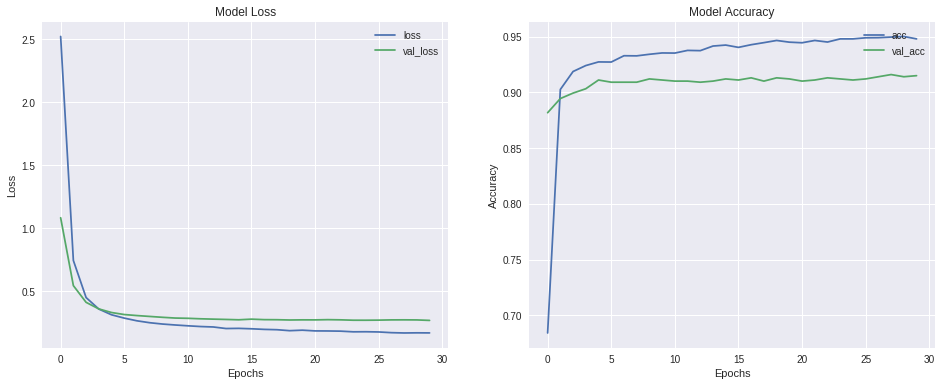

In [17]:
# Cell Settings
saving_weights=True

"""
External References:
  bfs_xception_split
  N_CLASSES
"""

# Reset fc_model
fc_model = fc_setup()

# Unpack training and validation data
x_tr = bfs_xception_split['x_tr']
y_tr = bfs_xception_split['y_tr']
x_cv = bfs_xception_split['x_cv']
y_cv = bfs_xception_split['y_cv']

# Sanity check
print_input_shapes(bfs_xception_split)

print("\n")

print("Fitting...")
# Train and evaluate model
history = fc_model.fit(x_tr, y_tr, 
                         batch_size=32, 
                         epochs=30, 
                         validation_data=(x_cv, y_cv))

print(fc_model.evaluate(x_cv, y_cv))
display(plot_model_history(history))

# Save weights, if applicable
if saving_weights:
  fc_model.save_weights('fc_model_weights/{}_{}.h5'.format('xception', IMG_DIM))

**Analysis of results**

(3, 87)


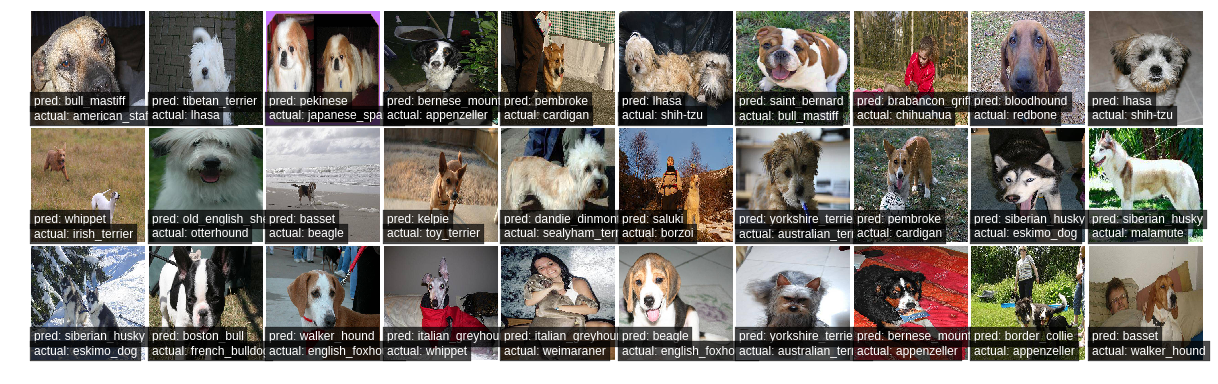

In [18]:
"""
External References:
  bfs_xception_split
  fc_model
  permut_cv
  num_to_class
"""

bfs_cv = bfs_xception_split['x_cv']
y_cv   = bfs_xception_split['y_cv']

x = orig_data['x']

errors_cv = get_errors(fc_model.predict(bfs_cv), y_cv)
print(errors_cv.shape)

# Error Visualization
show_errors(x[permut_cv], errors_cv, num_to_class)

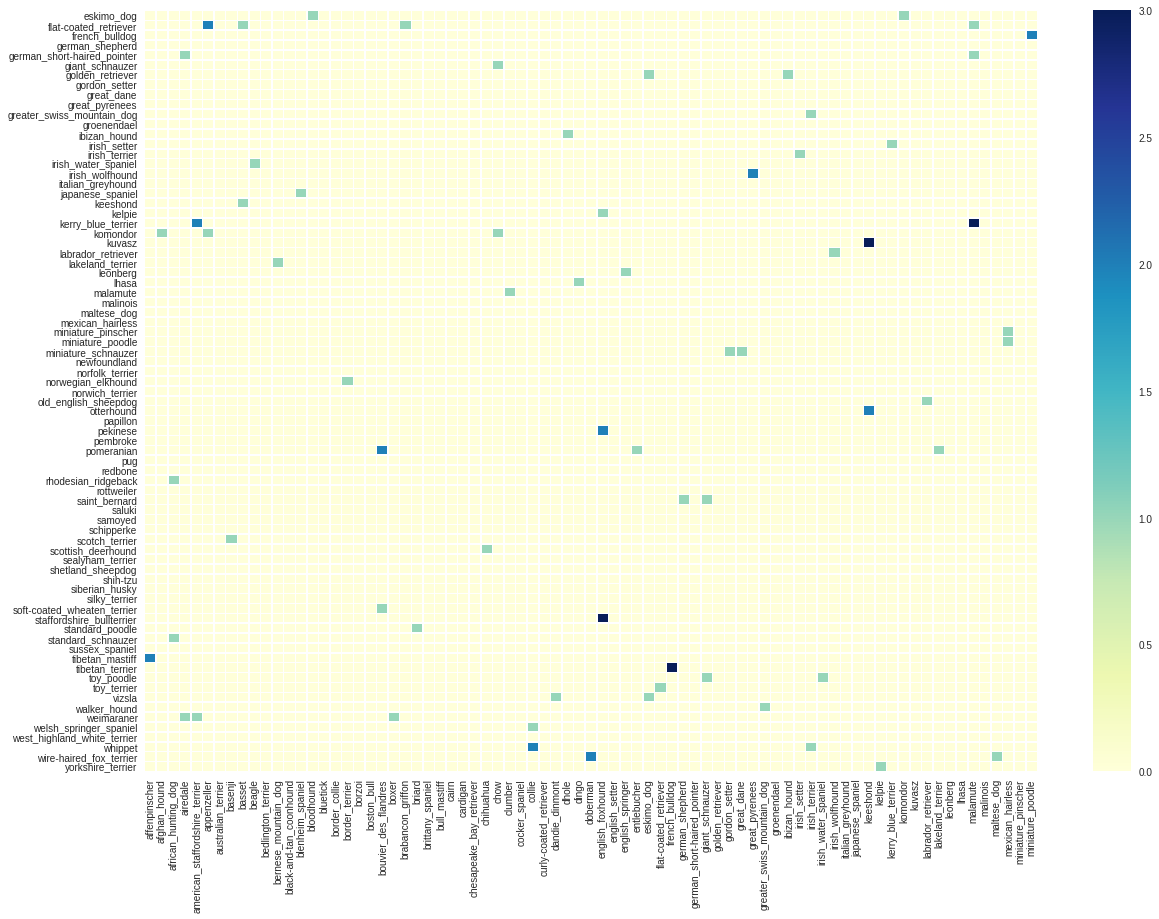

In [19]:
plot_confusion_matrix(errors_cv, N_CLASSES)

# Scraping Pixabay for More Data

In [0]:
!pip install -q python-pixabay

import python_pixabay
import urllib.request
import os

In [36]:
bfs   = bfs_xception_split['x']
y_cat = bfs_xception_split['y']

yhat = np.argmax(fc_model.predict(bfs), axis=1)
y    = np.argmax(y_cat, axis=1)

errors = (yhat != y)

err_per_breed = np.sum(y_cat[errors==1], axis=0)
err_per_breed = np.stack((np.array([num for num in range(120)]), err_per_breed))
err_per_breed.shape
# err_per_breed = err_per_breed[:, err_per_breed[1, :].argsort()]
print(err_per_breed.shape)

print(err_per_breed)


(2, 120)
[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
   14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
   28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
   42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
   56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
   70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
   84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
   98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
  112. 113. 114. 115. 116. 117. 118. 119.]
 [  1.   1.   0.   1.  13.  13.  10.   0.   0.   5.   0.   2.   6.   1.
    0.   4.   1.   0.   1.   2.   7.   3.   2.   4.   3.   2.   3.   5.
    1.   5.   0.   1.   1.  22.   2.   2.   2.   3.   2.  11.   3.   2.
    7.  34.   3.   3.   4.   1.   3.   5.   1.   0.   3.   6.   0.   3.
    0.   4.   1.   6.   3.   7.   1.   3.   2.   1.   3.   3.   9.   0.
    9.   9. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


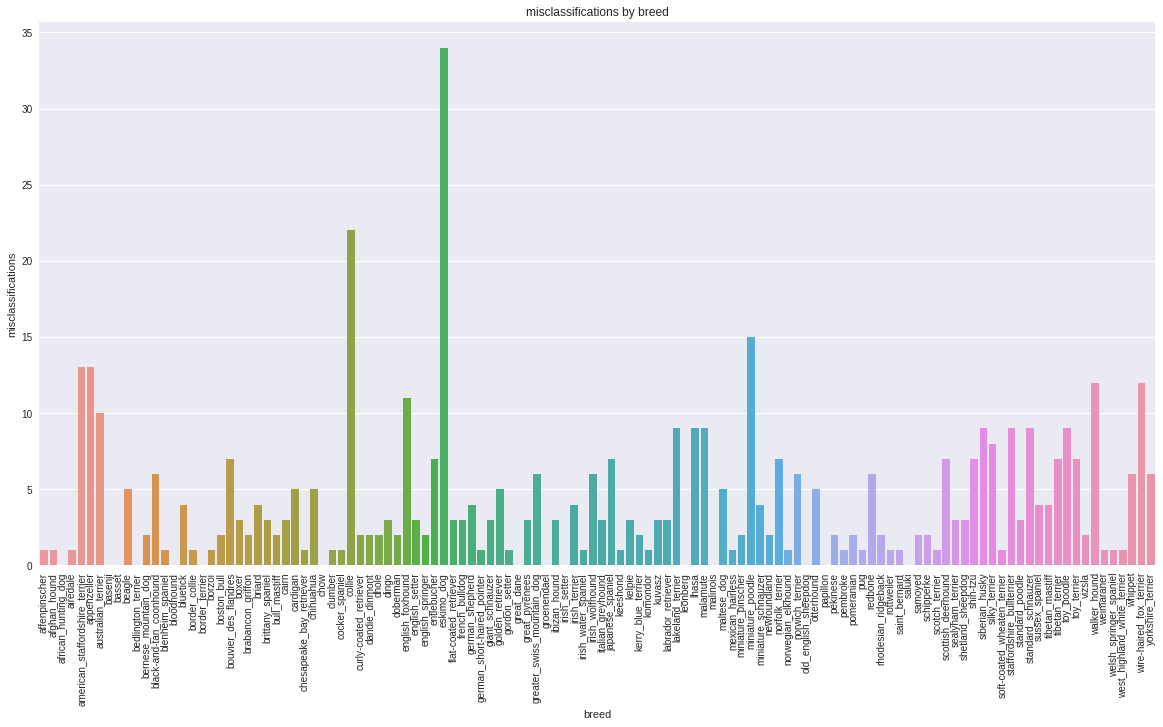

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x=err_per_breed[0], y=err_per_breed[1])

ax.set(title='misclassifications by breed', 
       xlabel='breed', 
       ylabel='misclassifications', 
       xticklabels=[num_to_class[n] for n in range(120)])

for item in ax.get_xticklabels():
  item.set_rotation(90)

In [0]:
def error_report(yhat_categorical, y_categorical, report_len=20):
  yhat = np.argmax(yhat_categorical, axis=1)
  y = np.argmax(y_categorical, axis=1)
  
  errors = (yhat != y)
  
  misclassified_counts = np.sum(y_categorical[errors==1], axis=0)
  
  # Generate and populate misses
  misses = []
  for i, errs in enumerate(misclassified_counts):
    breed = num_to_class[i]
    errors = errs
    misses.append((errors, breed))

  # sort misses by number of errors
  misses = sorted(misses, key=lambda tup: tup[0], reverse=True)

  # Print error report
  for (errs, breed) in misses[0:report_len]:
    print(errs, breed)
    
  return misses
  

In [35]:
x_tr = bfs_xception_split['x_tr']
y_tr = bfs_xception_split['y_tr']

miss_list = error_report(fc_model.predict(x_tr), y_tr)

27.0 eskimo_dog
18.0 collie
14.0 miniature_poodle
10.0 american_staffordshire_terrier
10.0 english_foxhound
10.0 walker_hound
9.0 appenzeller
9.0 australian_terrier
9.0 wire-haired_fox_terrier
8.0 irish_wolfhound
8.0 lakeland_terrier
8.0 siberian_husky
7.0 lhasa
7.0 norfolk_terrier
7.0 scottish_deerhound
7.0 silky_terrier
7.0 tibetan_terrier
7.0 toy_poodle
6.0 entlebucher
6.0 japanese_spaniel


In [0]:

def scrape_pixabay(api_key, breed, n_photos, source_path, printing=False):
  pix = python_pixabay.Pixabay(api_key)
  img_search = pix.image_search(q=breed,
                                lang='en',
                                image_type='photo',
                                category='animals',
                                safesearch=True,
                                per_page=n_photos)
  
  hits = img_search.get('hits')
  
  if not os.path.exists('{}/{}'.format(source_path, breed)):
    os.makedirs('{}/{}'.format(source_path, breed))
  
  urls = []
  for i, hit in enumerate(hits):
    
    target_path = '{}/{}/{}.jpg'.format(source_path, breed, i)
    url = hit['webformatURL']
    if printing:
      print(url)
    
    if not os.path.exists(target_path):
      urllib.request.urlretrieve(url, target_path)
      

In [0]:
top_n = 120
# Take top_n most misclassified breeds and place in list
breeds_to_augment = []
for (errs, breed) in miss_list[0:top_n]:
  breeds_to_augment.append(breed)

In [0]:
# Scrape pixabay for photos_each photos of each breed in breeds_to_augment

photos_each = 50

for breed in tqdm(breeds_to_augment):
  scrape_pixabay(api_key, breed, photos_each, source_path='scraped_photos', printing=False)

In [38]:
x_new_list = []
y_new_list = []

photos_to_use = 20

for breed in tqdm(breeds_to_augment):
  # Get list of photos in breed's directory
  path_list = os.listdir('scraped_photos/{}'.format(breed))
  n_examples = len(path_list)
  
  
  # Convert each photo in filepath to array representation, place in list
  x_imgs = []
  for i, imagepath in enumerate(path_list[0:photos_to_use]):
    arr = path_to_arr('scraped_photos/{}/{}'.format(breed, imagepath), IMG_DIM)
    if arr.shape[2] == 3:
      x_imgs.append(arr)
  
  if x_imgs:
    # Convert list of n (IMG_DIM, IMG_DIM, 3)dim matrices to single (n, IMG_DIM, IMG_DIM, 3)dim array
    x_breed = np.stack(x_imgs)

    # Add this breed's (n, IMG_DIM, IMG_DIM, 3)dim matrix to list for later concatenation
    x_new_list.append(x_breed)
    y_breed = np.ones((x_breed.shape[0], )) * class_to_num[breed]

    y_new_list.append(y_breed)

# stack m (n, IMG_DIM, IMG_DIM, 3) dim matrices to yield (mn, IMG_DIM, IMG_DIM, 3)dim matrix
x_new = np.concatenate(x_new_list, axis=0)
y_new = keras.utils.to_categorical(np.concatenate(y_new_list, axis=0), num_classes=N_CLASSES)

print(x_new.shape)
print(y_new.shape)

100%|██████████| 120/120 [07:09<00:00,  3.58s/it]


(880, 400, 400, 3)
(880, 120)


In [39]:
# Border collies frequently appear in searches for collies
not_collie = (np.argmax(y_new, axis=1) != class_to_num['collie'])
x_new = x_new[not_collie==1]
y_new = y_new[not_collie==1]

print(x_new.shape)
print(y_new.shape)

(860, 400, 400, 3)
(860, 120)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'number of new images')

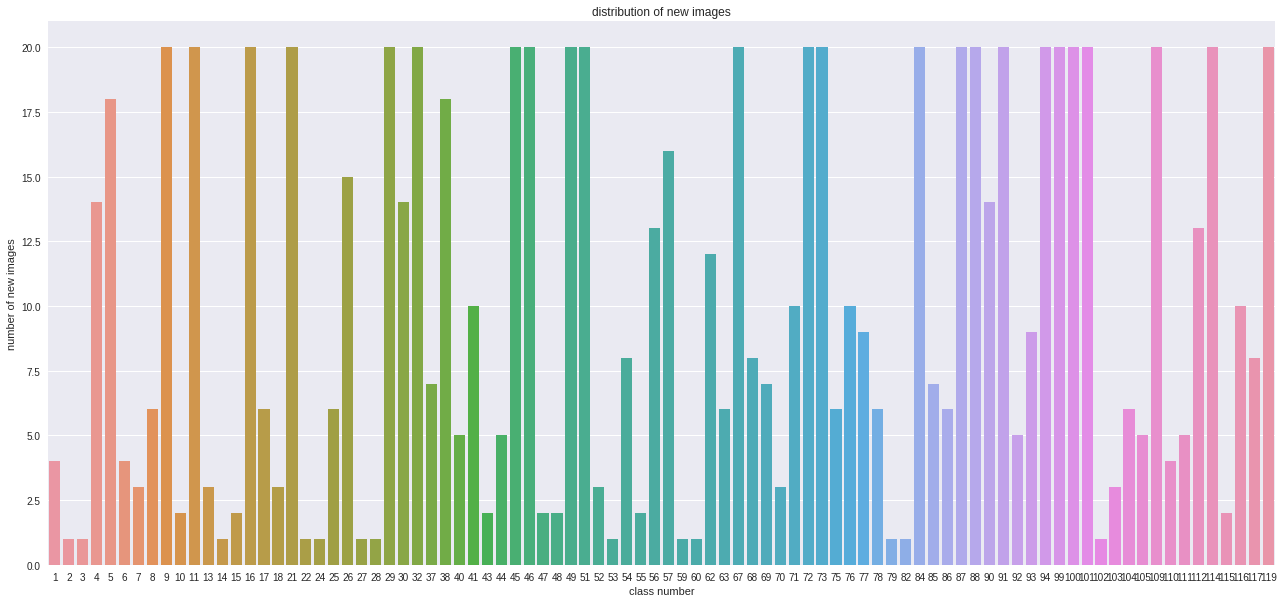

In [40]:
counts = np.argmax(y_new, axis=1)

fig = plt.figure(figsize=(22, 10))
fig = sns.countplot(counts)
fig.set_title('distribution of new images')
fig.set_xlabel('class number')
fig.set_ylabel('number of new images')

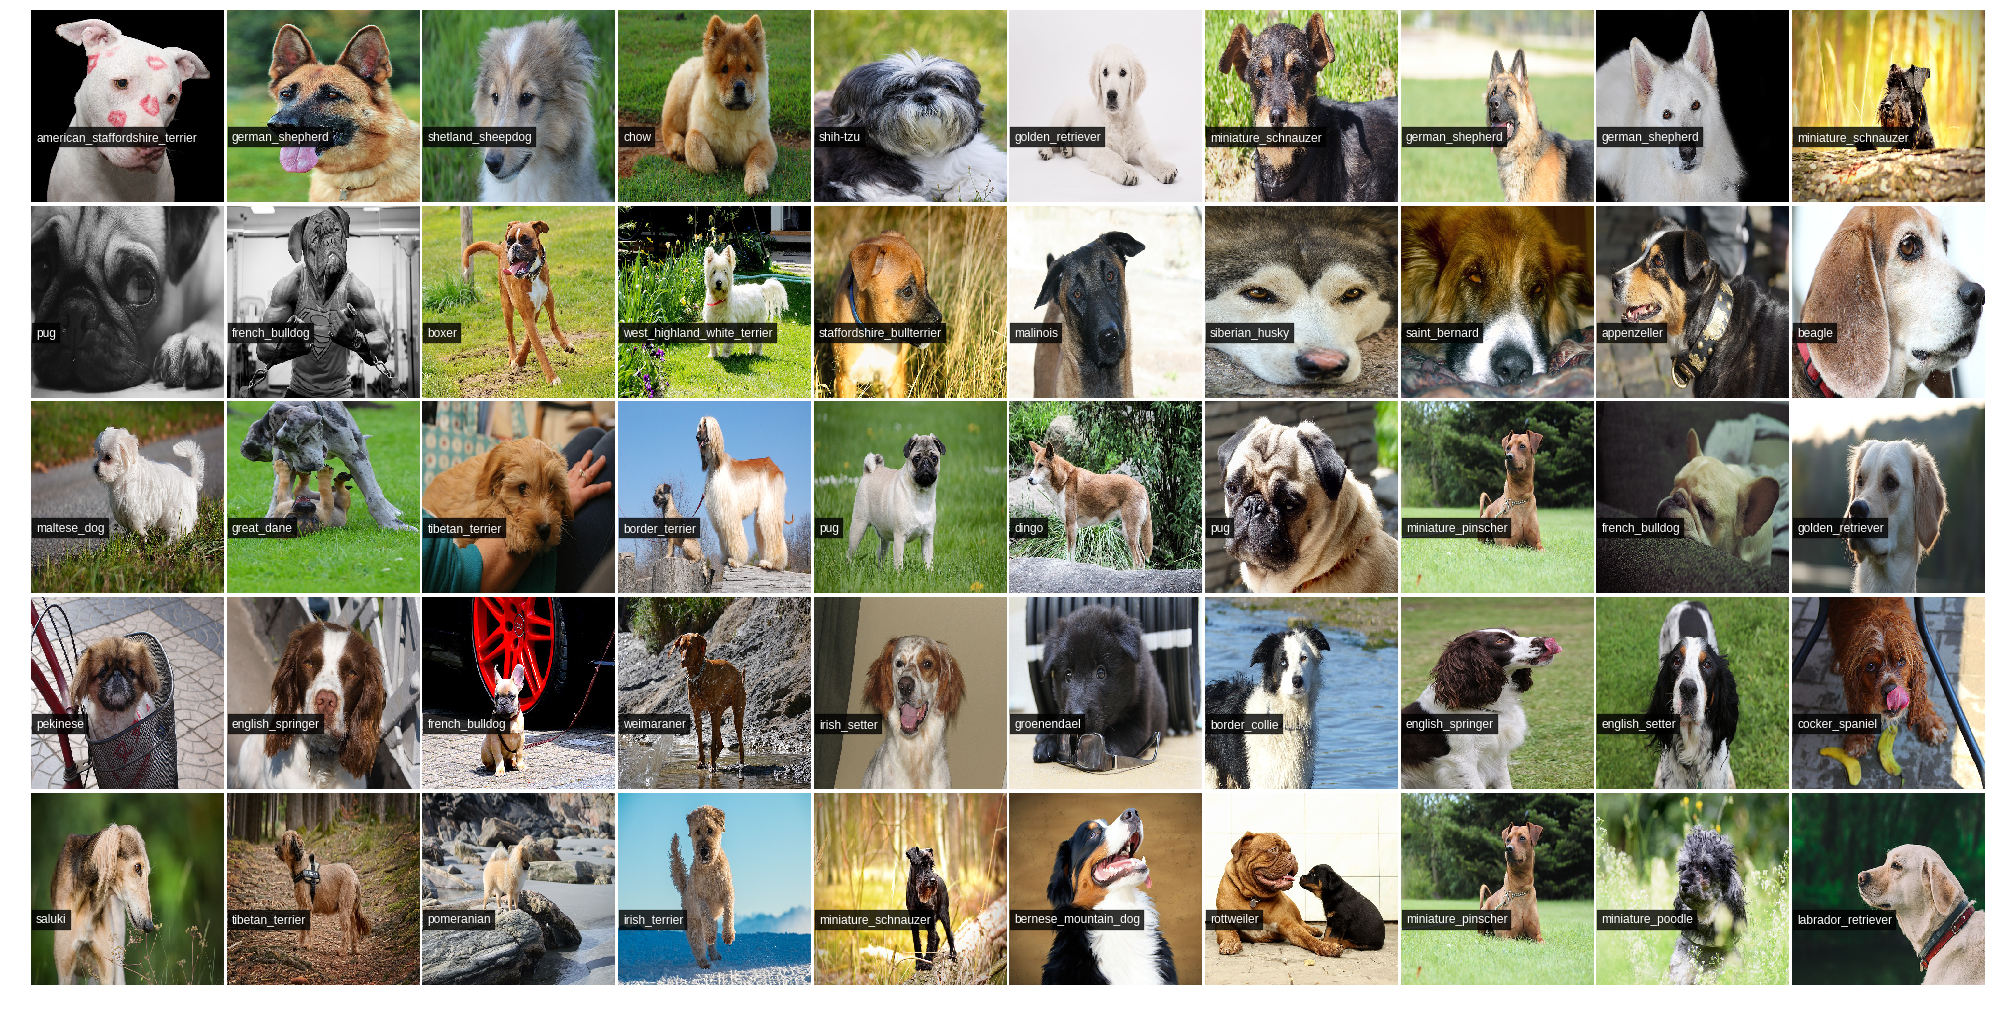

In [41]:
view_labeled_data(x=x_new, y=y_new, nrows=5, ncols=10, dim=7)

In [42]:
bfs_new_split = {'x_tr' : generate_bottleneck_features(xception_base, x_new), 
                 'y_tr' : y_new}

print_input_shapes(bfs_new_split)

NameError: ignored

In [79]:
bfs_new = bfs_new_split['x_tr']
y_new   = bfs_new_split['y_tr']

bfs_tr  = bfs_xception_split['x_tr']
y_tr    = bfs_xception_split['y_tr']

# Concatenate new bottleneck features to end of existing (training) bottleneck features
bfs_tr_aug = np.concatenate((bfs_tr, 
                             bfs_new), axis=0)

y_tr_aug   = np.concatenate((y_tr, 
                             y_new), axis=0)

# Shuffle augmented data set
permut = np.random.permutation(bfs_tr_aug.shape[0])
bfs_tr_aug = bfs_tr_aug[permut]
y_tr_aug = y_tr_aug[permut]

bfs_aug_split = {'x_tr' : bfs_tr_aug, 
                 'y_tr' : y_tr_aug}

print_input_shapes(bfs_aug_split)

x_tr.shape = (10059, 2048)
y_tr.shape = (10059, 120)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
probs (Dense)                (None, 120)               245880    
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________
x_tr.shape = (10059, 2048)
y_tr.shape = (10059, 120)
x_tr.shape = (9199, 2048)
y_tr.shape = (9199, 120)
x_cv.shape = (1023, 2048)
y_cv.shape = (1023, 120)


Fitting...
Train on 10059 samples, validate on 1023 samples
Epoch 1/15
10059/10059 [==============================] - 3s 321us/step - loss: 2.9416 - acc: 0.6628 - val_loss: 0.5996 - val_acc: 0.9071
Epoch 2/15
10059/10059 [=====================

10059/10059 [==============================] - 2s 169us/step - loss: 1.6773 - acc: 0.8250 - val_loss: 0.3537 - val_acc: 0.9071
Epoch 4/15
10059/10059 [==============================] - 2s 165us/step - loss: 1.6274 - acc: 0.8326 - val_loss: 0.3293 - val_acc: 0.9081
Epoch 5/15
10059/10059 [==============================] - 2s 165us/step - loss: 1.6016 - acc: 0.8355 - val_loss: 0.3189 - val_acc: 0.9081
Epoch 6/15
10059/10059 [==============================] - 2s 167us/step - loss: 1.5918 - acc: 0.8410 - val_loss: 0.3139 - val_acc: 0.9101
Epoch 7/15
10059/10059 [==============================] - 2s 163us/step - loss: 1.5847 - acc: 0.8392 - val_loss: 0.3132 - val_acc: 0.9042
Epoch 8/15
10059/10059 [==============================] - 2s 164us/step - loss: 1.5746 - acc: 0.8432 - val_loss: 0.3115 - val_acc: 0.9062
Epoch 9/15
 7072/10059 [====================>.........] - ETA: 0s - loss: 1.5399 - acc: 0.8477

10059/10059 [==============================] - 2s 165us/step - loss: 1.5594 - acc: 0.8442 - val_loss: 0.3074 - val_acc: 0.9091
Epoch 10/15
10059/10059 [==============================] - 2s 163us/step - loss: 1.5538 - acc: 0.8440 - val_loss: 0.3063 - val_acc: 0.9110
Epoch 11/15
10059/10059 [==============================] - 2s 164us/step - loss: 1.5471 - acc: 0.8464 - val_loss: 0.3113 - val_acc: 0.9091
Epoch 12/15
10059/10059 [==============================] - 2s 166us/step - loss: 1.5465 - acc: 0.8501 - val_loss: 0.3080 - val_acc: 0.9120
Epoch 13/15
10059/10059 [==============================] - 2s 166us/step - loss: 1.5419 - acc: 0.8515 - val_loss: 0.3067 - val_acc: 0.9101
Epoch 14/15
10059/10059 [==============================] - 2s 162us/step - loss: 1.5405 - acc: 0.8512 - val_loss: 0.3042 - val_acc: 0.9130
Epoch 15/15
 7072/10059 [====================>.........] - ETA: 0s - loss: 1.5296 - acc: 0.8566

1023/1023 [==============================] - 0s 78us/step
[0.30696150155069774, 0.907135874936075]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


None

NameError: ignored

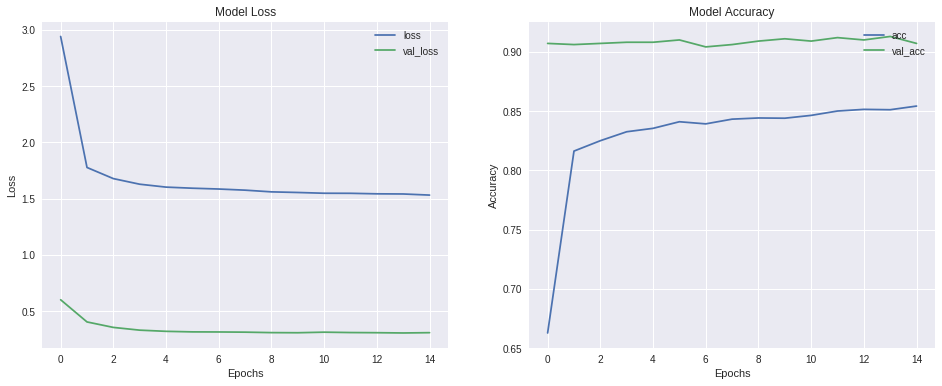

In [82]:
fc_model = fc_setup()

x_tr = bfs_aug_split['x_tr']
y_tr = bfs_aug_split['y_tr']

x_cv = bfs_xception_split['x_cv']
y_cv = bfs_xception_split['y_cv']


print_input_shapes(bfs_aug_split)
print_input_shapes(bfs_xception_split)

print("\n")

print("Fitting...")
history_1 = fc_model.fit(x_tr, y_tr, 
                         batch_size=32, 
                         epochs=15,
                         shuffle=True, 
                         validation_data=(x_cv, y_cv))

print(fc_model.evaluate(x_cv, y_cv))
display(plot_model_history(history_1))

fc_model.save_weights('fc_model_weights/{}classes_{}.h5'.format(N_CLASSES, base_type))

# Fine-Tuning Final Layers

In [21]:
# Define base model
xception_base = Xception(input_shape=(IMG_DIM, IMG_DIM, 3),
                         weights='imagenet', 
                         include_top=False, 
                         pooling='avg')

# Reset fc_model
fc_model = fc_setup()

# Load (pre-trained) fc_model weights
fc_model.load_weights('fc_model_weights/{}_{}.h5'.format('xception', IMG_DIM))


# Define full_model
model_input = Input(shape=(IMG_DIM, IMG_DIM, 3), name='model_input')
a = Lambda(keras.applications.xception.preprocess_input, name='preprocessing')(model_input)
bfs = xception_base(a)
probs = fc_model(bfs)

full_model = Model(inputs=model_input, outputs=probs)

# Unfreeze deep layers
layers_to_tune = 4
start_training = len(full_model.get_layer('xception').layers) - layers_to_tune

for layer in full_model.get_layer('xception').layers[:start_training]:
  layer.trainable = False
  
for layer in full_model.get_layer('xception').layers[start_training:]:
  layer.trainable = True
  
fc_model.trainable = True

# Recompile with slow learning rate
full_model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=1e-3, momentum=0.9), 
              metrics=['accuracy'])

full_model.summary()

print('base model layers = {}'.format(len(full_model.get_layer('xception').layers)))
print('frozen layers = {}'.format(len(full_model.get_layer('xception').layers[:start_training])))
print('unfrozen layers = {}'.format(len(full_model.get_layer('xception').layers[start_training:])))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
probs (Dense)                (None, 120)               245880    
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 400, 400, 3)       0         
_________________________________________________________________
preprocessing (Lambda)       (None, 400, 400, 3)       0         
_________________________________________________________________
xcep

In [0]:
full_model.load_weights('full_model_weights/{}_{}.h5'.format('xception', IMG_DIM))

In [6]:
x = orig_data['x']
y = orig_data['y']

print_input_shapes(orig_data)

print("Fitting...")
history_2 = full_model.fit(x, y, 
                           batch_size=32, 
                           epochs=15, 
                           shuffle=True,
                           validation_split=0.1)

print(full_model.evaluate(x, y))
plot_model_history(history_2)

NameError: ignored

In [0]:
 full_model.save_weights('full_model_weights/{}_{}.h5'.format('xception', IMG_DIM))

# Test Set Predictions and Submission

In [0]:
full_model.load_weights('full_model_weights/{}classes_{}.h5'.format(N_CLASSES, 'xception'))

In [0]:
loading_x_tst = True

df_out = pd.read_csv('Data/sample_submission.csv')
n_tst = len(df_out)

# Get test images in array representation
if loading_x_tst:
  x_tst = np.load('data_matrices/x_tst_{}.npy'.format(IMG_DIM))
else:
  df_out = pd.read_csv('Data/sample_submission.csv')
  n_tst = len(df_out)

  x_lst = []
  for id in tqdm(df_out['id']):
    imgpath = 'Data/test/{}.jpg'.format(id)
    x_lst.append(path_to_arr(imgpath))

  x_tst = np.stack(x_lst)
  
print(x_tst.shape)

In [27]:
# Make predictions
y_pred = full_model.predict(x_tst)

# Fill out submission csv
for num, breed in tqdm(num_to_class.items()):
  df_out[breed] = y_pred[:, num]
  
# Save csv  
df_out.to_csv('preds.csv', index=None)

100%|██████████| 120/120 [00:00<00:00, 1058.90it/s]


# Extracting Bottleneck Features for Ensembling

In [0]:
def load_bottleneck_features(model_name, img_dim):
  bfs = np.load('bottleneck_features/{}_{}.npy'.format(model_name, img_dim))
  print(bfs.shape)
  return bfs


def generate_bottleneck_features(x, model_constructor, model_preprocessor, img_dim, saving=True, model_name=None):
  tensor_shape = (img_dim, img_dim, 3)
  
  # Define base CNN
  base_model = model_constructor(input_shape=tensor_shape, 
                                 weights='imagenet', 
                                 include_top=False, 
                                 pooling='avg')
  
  # Model layers
  model_input = Input(shape=tensor_shape, name='model_input')
  a = Lambda(model_preprocessor, name='preprocessing')(model_input)
  a = base_model(a)
  
  # Define bfs_model
  bfs_model = Model(inputs=model_input, outputs=a)
  
  # Generate bottleneck features
  bfs = bfs_model.predict(x)
  
  if saving:
    np.save('bottleneck_features/{}_{}.npy'.format(model_name, img_dim), bfs)
    
  print(bfs.shape)
  return bfs
  

In [31]:
# Xception Bottleneck Features
from keras.applications.xception import Xception, preprocess_input

loading_xception_bfs = True
generating_xception_bfs = False

if loading_xception_bfs:
  bfs_xception = load_bottleneck_features('xception', IMG_DIM)

elif generating_xception_bfs:
  x = orig_data['x']
  bfs_xception = generate_bottleneck_features(x, 
                                              model_constructor=Xception, 
                                              model_preprocessor=keras.applications.xception.preprocess_input, 
                                              img_dim=IMG_DIM, 
                                              saving=True, 
                                              model_name='xception')

(10222, 2048)


In [32]:
# InceptionV3 Bottleneck Features
from keras.applications.inception_v3 import InceptionV3, preprocess_input

loading_inception_bfs = True
generating_inception_bfs = False

if loading_inception_bfs:
  bfs_inception = load_bottleneck_features('inception', IMG_DIM)
  
elif generating_inception_bfs:
  x = orig_data['x']
  bfs_inception = generate_bottleneck_features(x, 
                                               model_constructor=InceptionV3, 
                                               model_preprocessor=keras.applications.inception_v3.preprocess_input, 
                                               img_dim=IMG_DIM, 
                                               saving=True, 
                                               model_name='inception')

(10222, 2048)


In [33]:
# InceptionResNet Bottleneck Features
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

loading_irn_bfs = True
generating_irn_bfs = False

if loading_irn_bfs:
  bfs_irn = load_bottleneck_features('inceptionresnet', IMG_DIM)

elif generating_irn_bfs:
  x = orig_data['x']
  bfs_irn = generate_bottleneck_features(x, 
                                         model_constructor=InceptionResNetV2, 
                                         model_preprocessor=keras.applications.inception_v3.preprocess_input, 
                                         img_dim=IMG_DIM, 
                                         saving=True, 
                                         model_name='inceptionresnet')

(10222, 1536)


In [17]:
loading_ensem_features = True
generating_ensem_features = False

if loading_ensem_features:
  bfs_ensem = np.load('bottleneck_features/ensem_{}.npy'.format(IMG_DIM))
  
elif generating_ensem_features:
  # Concatenating Bottleneck Features
  bfs_ensem = np.concatenate([bfs_xception, bfs_irn, bfs_inception], axis=1)
  np.save('bottleneck_features/ensem_{}.npy'.format(IMG_DIM), bfs_ensem)
  
print(bfs_ensem.shape)


(10222, 5632)


# PCA on Ensembled Bottleneck Features

In [0]:
def fc_setup_pca(n_components):
  model_input = Input((n_components, ), name='model_input')
  probs = Dense(N_CLASSES, activation='softmax', name='probs')(model_input)
  
  fc_model = Model(inputs=model_input, outputs=probs)
  
  fc_model.compile(loss='categorical_crossentropy', 
                   optimizer='adadelta', 
                   metrics=['accuracy'])
  
  fc_model.summary()
  
  return fc_model

In [19]:
from sklearn.decomposition import PCA

n_components = 128

pca = PCA(n_components=n_components)
pca.fit(bfs_ensem)
bfs_pca = pca.transform(bfs_ensem)

print(bfs_pca.shape)

(10222, 128)


In [21]:
# Cell Settings
saving_pca_fc_weights = False

y = orig_data['y']

fc_model = fc_setup_pca(n_components)

fc_model.fit(bfs_pca, y, batch_size=32, epochs=30, validation_split=0.1)

if saving_pca_fc_weights:
  fc_model.save_weights('fc_model_weights/{}_{}.h5'.format('pca', IMG_DIM))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 128)               0         
_________________________________________________________________
probs (Dense)                (None, 120)               15480     
Total params: 15,480
Trainable params: 15,480
Non-trainable params: 0
_________________________________________________________________
Train on 9199 samples, validate on 1023 samples
Epoch 1/30
9199/9199 [==============================] - 1s 141us/step - loss: 2.9148 - acc: 0.5476 - val_loss: 1.3508 - val_acc: 0.8905
Epoch 2/30
9199/9199 [==============================] - 1s 133us/step - loss: 0.7803 - acc: 0.9141 - val_loss: 0.4613 - val_acc: 0.9277
Epoch 3/30
9199/9199 [==============================] - 1s 135us/step - loss: 0.3468 - acc: 0.9372 - val_loss: 0.2842 - val_acc: 0.9374
Epoch 4/30
9199/9199 [==============================] - 1s 133us/step - loss: 

9199/9199 [==============================] - 1s 133us/step - loss: 0.2088 - acc: 0.9473 - val_loss: 0.2080 - val_acc: 0.9423
Epoch 6/30
9199/9199 [==============================] - 1s 134us/step - loss: 0.1889 - acc: 0.9502 - val_loss: 0.1956 - val_acc: 0.9453
Epoch 7/30
9199/9199 [==============================] - 1s 135us/step - loss: 0.1759 - acc: 0.9516 - val_loss: 0.1873 - val_acc: 0.9462
Epoch 8/30
9199/9199 [==============================] - 1s 135us/step - loss: 0.1667 - acc: 0.9542 - val_loss: 0.1827 - val_acc: 0.9472
Epoch 9/30
9199/9199 [==============================] - 1s 134us/step - loss: 0.1593 - acc: 0.9545 - val_loss: 0.1782 - val_acc: 0.9443
Epoch 10/30
9199/9199 [==============================] - 1s 136us/step - loss: 0.1534 - acc: 0.9564 - val_loss: 0.1764 - val_acc: 0.9462
Epoch 11/30
9199/9199 [==============================] - 1s 133us/step - loss: 0.1483 - acc: 0.9571 - val_loss: 0.1737 - val_acc: 0.9472
Epoch 12/30
6208/9199 [===================>..........] - 

9199/9199 [==============================] - 1s 133us/step - loss: 0.1439 - acc: 0.9576 - val_loss: 0.1731 - val_acc: 0.9501
Epoch 13/30
9199/9199 [==============================] - 1s 131us/step - loss: 0.1399 - acc: 0.9585 - val_loss: 0.1711 - val_acc: 0.9472
Epoch 14/30
9199/9199 [==============================] - 1s 134us/step - loss: 0.1363 - acc: 0.9600 - val_loss: 0.1701 - val_acc: 0.9462
Epoch 15/30
9199/9199 [==============================] - 1s 132us/step - loss: 0.1330 - acc: 0.9610 - val_loss: 0.1704 - val_acc: 0.9472
Epoch 16/30
9199/9199 [==============================] - 1s 137us/step - loss: 0.1300 - acc: 0.9609 - val_loss: 0.1702 - val_acc: 0.9501
Epoch 17/30
9199/9199 [==============================] - 1s 134us/step - loss: 0.1275 - acc: 0.9627 - val_loss: 0.1693 - val_acc: 0.9511
Epoch 18/30
9199/9199 [==============================] - 1s 136us/step - loss: 0.1249 - acc: 0.9636 - val_loss: 0.1688 - val_acc: 0.9531
Epoch 19/30
6752/9199 [=====================>........

9199/9199 [==============================] - 1s 133us/step - loss: 0.1222 - acc: 0.9648 - val_loss: 0.1677 - val_acc: 0.9501
Epoch 20/30
9199/9199 [==============================] - 1s 135us/step - loss: 0.1200 - acc: 0.9656 - val_loss: 0.1685 - val_acc: 0.9531
Epoch 21/30
9199/9199 [==============================] - 1s 131us/step - loss: 0.1181 - acc: 0.9658 - val_loss: 0.1671 - val_acc: 0.9511
Epoch 22/30
9199/9199 [==============================] - 1s 129us/step - loss: 0.1159 - acc: 0.9673 - val_loss: 0.1683 - val_acc: 0.9521
Epoch 23/30
9199/9199 [==============================] - 1s 130us/step - loss: 0.1139 - acc: 0.9668 - val_loss: 0.1677 - val_acc: 0.9501
Epoch 24/30
9199/9199 [==============================] - 1s 132us/step - loss: 0.1120 - acc: 0.9674 - val_loss: 0.1693 - val_acc: 0.9531
Epoch 25/30
9199/9199 [==============================] - 1s 134us/step - loss: 0.1105 - acc: 0.9676 - val_loss: 0.1683 - val_acc: 0.9501
Epoch 26/30
7072/9199 [======================>.......

9199/9199 [==============================] - 1s 133us/step - loss: 0.1089 - acc: 0.9679 - val_loss: 0.1686 - val_acc: 0.9511
Epoch 27/30
9199/9199 [==============================] - 1s 136us/step - loss: 0.1071 - acc: 0.9685 - val_loss: 0.1695 - val_acc: 0.9521
Epoch 28/30
9199/9199 [==============================] - 1s 134us/step - loss: 0.1057 - acc: 0.9697 - val_loss: 0.1693 - val_acc: 0.9531
Epoch 29/30
9199/9199 [==============================] - 1s 135us/step - loss: 0.1043 - acc: 0.9703 - val_loss: 0.1680 - val_acc: 0.9521
Epoch 30/30
9199/9199 [==============================] - 1s 135us/step - loss: 0.1028 - acc: 0.9699 - val_loss: 0.1684 - val_acc: 0.9511


In [22]:
# Train on entire dataset

# Cell Settings
saving_pca_fc_weights = True

y = orig_data['y']

fc_model = fc_setup_pca(n_components)

fc_model.fit(bfs_pca, y, batch_size=32, epochs=25)

if saving_pca_fc_weights:
  fc_model.save_weights('fc_model_weights/{}_{}.h5'.format('pca', IMG_DIM))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 128)               0         
_________________________________________________________________
probs (Dense)                (None, 120)               15480     
Total params: 15,480
Trainable params: 15,480
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
10222/10222 [==============================] - 1s 118us/step - loss: 2.6882 - acc: 0.5877
Epoch 2/25
10222/10222 [==============================] - 1s 117us/step - loss: 0.6595 - acc: 0.9246
Epoch 3/25
10222/10222 [==============================] - 1s 128us/step - loss: 0.3070 - acc: 0.9400
Epoch 4/25
10222/10222 [==============================] - 1s 131us/step - loss: 0.2295 - acc: 0.9454
Epoch 5/25
 4480/10222 [============>.................] - ETA: 0s - loss: 0.1922 - acc: 0.9520

10222/10222 [==============================] - 1s 131us/step - loss: 0.1986 - acc: 0.9483
Epoch 6/25
10222/10222 [==============================] - 1s 131us/step - loss: 0.1820 - acc: 0.9504
Epoch 7/25
10222/10222 [==============================] - 1s 133us/step - loss: 0.1705 - acc: 0.9521
Epoch 8/25
10222/10222 [==============================] - 1s 131us/step - loss: 0.1623 - acc: 0.9536
Epoch 9/25
10222/10222 [==============================] - 1s 129us/step - loss: 0.1558 - acc: 0.9539
Epoch 10/25
10222/10222 [==============================] - 1s 135us/step - loss: 0.1500 - acc: 0.9559
Epoch 11/25
10222/10222 [==============================] - 1s 131us/step - loss: 0.1456 - acc: 0.9567
Epoch 12/25
10222/10222 [==============================] - 1s 133us/step - loss: 0.1414 - acc: 0.9577
Epoch 13/25
 2112/10222 [=====>........................] - ETA: 1s - loss: 0.1162 - acc: 0.9598

10222/10222 [==============================] - 1s 128us/step - loss: 0.1379 - acc: 0.9590
Epoch 14/25
10222/10222 [==============================] - 1s 133us/step - loss: 0.1342 - acc: 0.9599
Epoch 15/25
10222/10222 [==============================] - 1s 133us/step - loss: 0.1315 - acc: 0.9607
Epoch 16/25
10222/10222 [==============================] - 1s 132us/step - loss: 0.1286 - acc: 0.9621
Epoch 17/25
10222/10222 [==============================] - 1s 133us/step - loss: 0.1260 - acc: 0.9626
Epoch 18/25
10222/10222 [==============================] - 1s 131us/step - loss: 0.1236 - acc: 0.9631
Epoch 19/25
10222/10222 [==============================] - 1s 131us/step - loss: 0.1213 - acc: 0.9646
Epoch 20/25
10222/10222 [==============================] - 1s 125us/step - loss: 0.1192 - acc: 0.9654
Epoch 21/25
 1536/10222 [===>..........................] - ETA: 1s - loss: 0.1157 - acc: 0.9707

10222/10222 [==============================] - 1s 129us/step - loss: 0.1169 - acc: 0.9656
Epoch 22/25
10222/10222 [==============================] - 1s 129us/step - loss: 0.1153 - acc: 0.9669
Epoch 23/25
10222/10222 [==============================] - 1s 128us/step - loss: 0.1132 - acc: 0.9671
Epoch 24/25
10222/10222 [==============================] - 1s 129us/step - loss: 0.1116 - acc: 0.9678
Epoch 25/25
10222/10222 [==============================] - 1s 129us/step - loss: 0.1100 - acc: 0.9692


**Generate bottleneck Features for test data**

In [27]:
x_tst = np.load('data_matrices/x_tst_{}.npy'.format(IMG_DIM))

print('generating xception bottleneck features...')
x_xception = generate_bottleneck_features(x_tst, 
                                          model_constructor=Xception, 
                                          model_preprocessor=keras.applications.xception.preprocess_input, 
                                          img_dim=IMG_DIM, 
                                          saving=True, 
                                          model_name='xception_tst')

print('generating inception bottleneck features...')
x_inception = generate_bottleneck_features(x_tst, 
                                           model_constructor=InceptionV3, 
                                           model_preprocessor=keras.applications.inception_v3.preprocess_input, 
                                           img_dim=IMG_DIM, 
                                           saving=True, 
                                           model_name='inception_tst')

print('generating inceptionresnet bottleneck features...')
x_irn = generate_bottleneck_features(x_tst,
                                     model_constructor=InceptionResNetV2, 
                                     model_preprocessor=keras.applications.inception_resnet_v2.preprocess_input, 
                                     img_dim=IMG_DIM, 
                                     saving=True, 
                                     model_name='inceptionResNetV2_tst')

tst_ensem = np.concatenate([x_xception, x_irn, x_inception], axis=1)
print(tst_ensem.shape)
np.save('bottleneck_features/tst_ensem_{}'.format(IMG_DIM), tst_ensem)

generating xception bottleneck features...
(10357, 2048)


In [0]:
# Get ensembled bottleneck features
tst_ensem = np.load('bottleneck_features/tst_ensem_{}.npy'.format(IMG_DIM))

# fc_model = fc_setup_pca(n_components)
# fc_model.load_weights('fc_model_weights/{}_{}.h5'.format('pca', IMG_DIM))

tst_pca = pca.transform(tst_ensem)

y_preds = fc_model.predict(tst_pca)

In [27]:
df_out = pd.read_csv('Data/sample_submission.csv')
# Fill out submission csv
for num, breed in tqdm(num_to_class.items()):
  df_out[breed] = y_preds[:, num]
  
# Save csv  
df_out.to_csv('Data/preds.csv', index=None)

100%|██████████| 120/120 [00:00<00:00, 1155.00it/s]
